In [3]:
# general
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2

# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

### Structure
- plot images
- data loader
- image augmentation
- text preprocessing

### Plot images

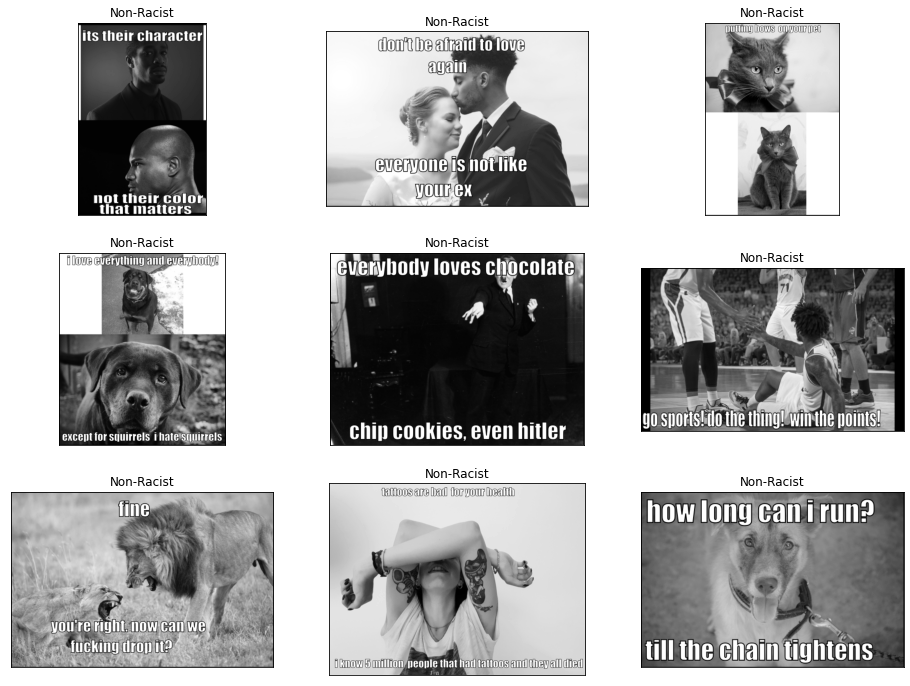

In [4]:
dataset_df = pd.read_json('../data/train.jsonl', lines=True)

# plot a few images together with labels
nx = 3
ny = 3

fig, ax = plt.subplots(figsize=(16, ny*4), nrows=ny, ncols=nx)
for i in range(ny):
    for j in range(nx):
        img_id = dataset_df['id'].values[i*nx+ j]
        
        # catch trailing 0
        if img_id < 1e4:
            img = cv2.imread('../data/img/0'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread('../data/img/'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)  
        
        # plot and remove axes
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_title('Racist' if dataset_df['label'].values[i*nx+ j] else 'Non-Racist')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
        
plt.show()

### Dataloader

In [45]:
class HatefulMemesDataset(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, df_path, root_dir, normalize=False, transform=None):
        """
        Args:
            df_path (string): path to jsonl file with image id's
            root_dir (string): directory with all the images
            transform (callable): optional transform to be applied on a sample
        """
        self.meme = pd.read_json(df_path, lines=True)
        self.root_dir = root_dir
        self.normalize = normalize
        self.transform = transform
        
    def __len__(self):
        return len(self.meme)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
        
        
        # catch trailing 0
        if self.meme['id'][idx] < 1e4:
            img_name = os.path.join(self.root_dir, '0'+ str(self.meme['id'][idx])+ '.png')
        else:
            img_name = os.path.join(self.root_dir, str(self.meme['id'][idx])+ '.png')
        
        image = cv2.imread(img_name)
        
        if self.normalize:
            # TODO: normalize image by mean and std -> what data type do networks require?
            print('TODO')
        
        # text
        text = self.meme['text'][idx]
        
        # label
        label = self.meme['label'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        #
        sample = {'image': image, 'text': text, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

0 (400, 265, 3) (1,)
its their character not their color that matters
1 (533, 800, 3) (1,)
don't be afraid to love again everyone is not like your ex
2 (800, 558, 3) (1,)
putting bows on your pet
3 (800, 693, 3) (1,)
i love everything and everybody! except for squirrels i hate squirrels


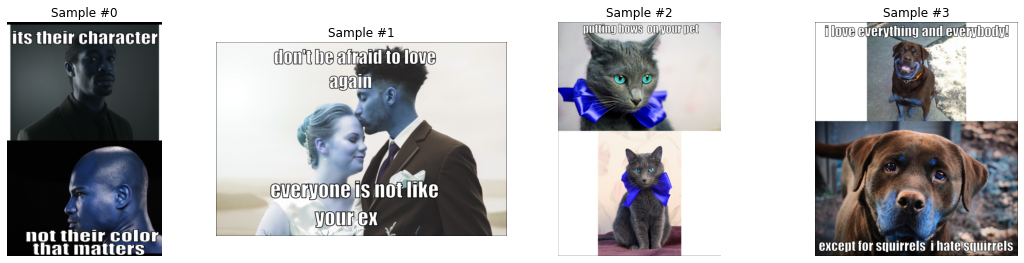

In [49]:
memes_dataset = HatefulMemesDataset(df_path='../data/train.jsonl', root_dir='../data/img', normalize=False)

fig = plt.figure(figsize=(16, 4))

for i in range(len(memes_dataset)):
    sample = memes_dataset[i]

    print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    #ax.set_xlabel(sample['text'])
    print(sample['text'])
    ax.axis('off')
    
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

### Image augmentation

In [50]:
# aspect ratio = 1.3 (width / height) median
# image dimensions = 128 x 128 (16k pixels) for CNN's

class Rescale(object):
    """Rescale the image in a sample to a given size
    Args:
        img_width (int): desired width of image
        max_distortion (float): maximum distortion of an image in a given direction
    """
    
    def __init__(self, size, max_distortion):
        self.size = size
        self.max_distortion = max_distortion
        
    def __call__(self, sample):
        image, text, label = sample['image'], sample['text'], sample['label']
        
        #
        width, height = image.shape[:2]
        aspect_ratio = width/ height
        
        # resulting distortion too high -> padding
        if aspect_ratio > self.max_distortion:
            pad = width- 2*height
            img = cv2.copyMakeBorder(image, int(pad/2.), int(pad/2.), 0, 0, cv2.BORDER_CONSTANT)
        elif 1./aspect_ratio > self.max_distortion:
            pad = height- 2*width
            img = cv2.copyMakeBorder(image, 0, 0, int(pad/2.), int(pad/2.), cv2.BORDER_CONSTANT)  
        else:
            img = image.copy()
            
        # resize image
        img = transform.resize(img, (self.size, self.size))
        
        return {'image': img, 'text': text, 'label': label}

In [51]:
# cropping, scaling, rotation, noise, color?
class Transform(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self):
        pass
        
    def __call__(self, sample):
        image, text, label = sample['image'], sample['text'], sample['label']
        
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.RandomRotation(degrees=(-20, 20))])
        
        img = (255.* image).astype(np.uint8)
        img = transform(img.astype(np.uint8))
        
        
        return {'image': img, 'text': text, 'label': label}

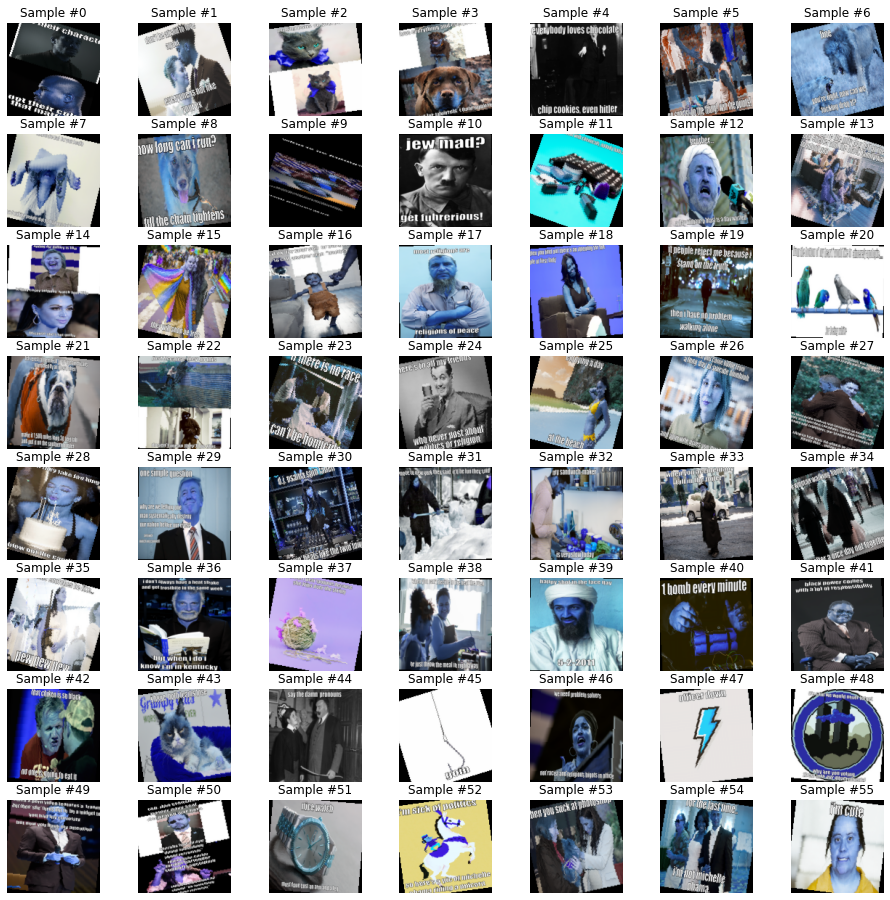

In [53]:
# dataset
composed = transforms.Compose([Rescale(128, 2.),
                               Transform()])

memes_dataset = HatefulMemesDataset(df_path='../data/train.jsonl', root_dir='../data/img',
                                    normalize=False, transform=composed)

#plot
ncols = 7
nrows = 8
fig, ax = plt.subplots(figsize=(16, 16), ncols=ncols, nrows=nrows)

for i in range(ncols*nrows):
    x = i%ncols 
    y = int(i/ncols)
    
    sample = memes_dataset[i]

    ax[y,x].imshow(sample['image'])
    ax[y,x].set_title('Sample #{}'.format(i))
    ax[y,x].axis('off')

plt.show()

### Text Preprocessing

- 